<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-2-public/blob/adding_C2/C2/W1/assignment/C2_W1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Copyright 2018 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [3]:
try:
    %tensorflow_version 2.x
except:
    pass

In [4]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

2023-05-31 16:54:46.282389: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 16:54:46.774706: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 16:54:46.776542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 16:54:48.483129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


• Using TensorFlow Version: 2.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Not Found. Running on CPU


# Download Fashion MNIST Dataset

We will use TensorFlow Datasets to load the Fashion MNIST dataset. 

**IMPORTANT NOTE:** The tfds `ALL` split has been deprecated in the latest TensorFlow version. If you are running this file on Coursera, kindly use the code:
```python
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

filePath = f"{getcwd()}/../tmp2/"
splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits, data_dir=filePath)

(train_examples, validation_examples, test_examples) = splits

```




If you are running the file on your local machine with the latest TensorFlow version or using Google Colab, comment out the above code and uncomment this code:

```python
(train_examples, validation_examples, test_examples), info = tfds.load('fashion_mnist', 
                                                                       with_info=True, 
                                                                       as_supervised=True, 
                                                                       split=['train[:80%]',
                                                                              'train[80%:90%]',
                                                                              'train[90%:]'])
```


In [5]:
# splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

# filePath = f"{getcwd()}/../tmp2/"
# splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits, data_dir=filePath)

# (train_examples, validation_examples, test_examples) = splits

(train_examples, validation_examples, test_examples), info = tfds.load('fashion_mnist', 
                                                                       with_info=True, 
                                                                       as_supervised=True, 
                                                                       split=['train[:80%]',
                                                                              'train[80%:90%]',
                                                                              'train[90%:]'])

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

The class names are not included with the dataset, so we will specify them here.

In [6]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [8]:
# The images in the dataset are 28 by 28 pixels.
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [13]:
# EXERCISE: Write a function to normalize the images.

def format_example(image, label):
    # Cast image to float32
    image = tf.cast(image, tf.float32)  # YOUR CODE HERE
        
    # Normalize the image in the range [0, 1]
    image = image/255.0 # YOUR CODE HERE
    
    return image, label

In [14]:
# Specify the batch size
BATCH_SIZE = 256

## Create Datasets From Images and Labels

In [15]:
# Create Datasets
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.batch(1).map(format_example)

# Building the Model

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
```

In [20]:
# EXERCISE: Build and compile the model shown in the previous cell.

model = tf.keras.Sequential([
    # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,
    tf.keras.layers.Conv2D(16, 3, input_shape=(28, 28, 1), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    # Flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),
    # Add a fully connected layer with 64 hidden units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),
    # Attach a final softmax classification head
    tf.keras.layers.Dense(10, activation='softmax')])

# Set the appropriate loss function and use accuracy as your metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train

In [21]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10
187/188 [============================>.] - ETA: 0s - loss: 0.6112 - accuracy: 0.7949

2023-05-31 17:15:16.632062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-31 17:15:16.632705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


188/188 [==============================] - 12s 55ms/step - loss: 0.6111 - accuracy: 0.7949 - val_loss: 0.4100 - val_accuracy: 0.8508
Epoch 2/10
188/188 [==============================] - 9s 47ms/step - loss: 0.3783 - accuracy: 0.8671 - val_loss: 0.3616 - val_accuracy: 0.8712
Epoch 3/10
188/188 [==============================] - 9s 48ms/step - loss: 0.3316 - accuracy: 0.8828 - val_loss: 0.3254 - val_accuracy: 0.8847
Epoch 4/10
188/188 [==============================] - 9s 47ms/step - loss: 0.2986 - accuracy: 0.8933 - val_loss: 0.3030 - val_accuracy: 0.8908
Epoch 5/10
188/188 [==============================] - 9s 47ms/step - loss: 0.2824 - accuracy: 0.8983 - val_loss: 0.2958 - val_accuracy: 0.8957
Epoch 6/10
188/188 [==============================] - 9s 47ms/step - loss: 0.2587 - accuracy: 0.9071 - val_loss: 0.2737 - val_accuracy: 0.9032
Epoch 7/10
188/188 [==============================] - 9s 48ms/step - loss: 0.2427 - accuracy: 0.9110 - val_loss: 0.2525 - val_accuracy: 0.9085
Epoch 8/1

# Exporting to TFLite

You will now save the model to TFLite. We should note, that you will probably see some warning messages when running the code below. These warnings have to do with software updates and should not cause any errors or prevent your code from running. 

In [22]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [23]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [25]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) # YOUR CODE HERE

# Set the optimzations
converter.optimizations = [optimization] # YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert() # YOUR CODE HERE

2023-05-31 17:29:51.908320: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-31 17:29:51.908356: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-31 17:29:51.909575: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: saved_model/1
2023-05-31 17:29:51.911481: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-31 17:29:51.911501: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: saved_model/1
2023-05-31 17:29:51.915911: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-31 17:29:51.917165: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-31 17:29:51.964297: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: saved_model/1
2023-05-31 17:29

In [26]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

259816

# Test the Model with TFLite Interpreter 

In [27]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [28]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

2023-05-31 17:32:30.885937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-31 17:32:30.886511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-31 17:32:30.973369: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

In [29]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)), class_names, rotation='vertical')
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

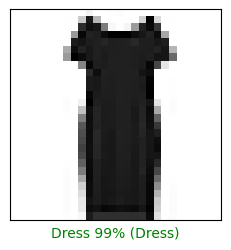

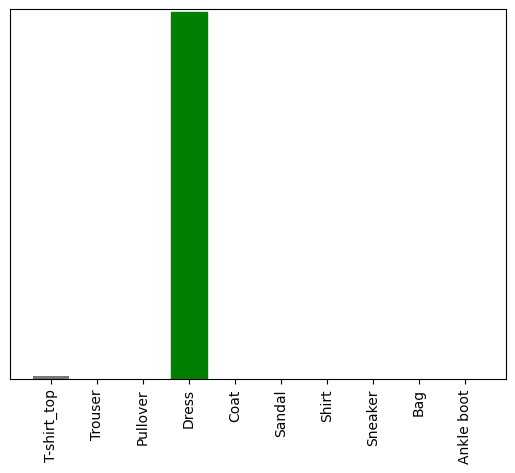

In [30]:
#@title Visualize the outputs { run: "auto" }
index = 12 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Download the TFLite Model and Assets

If you are running this notebook in a Colab, you can run the cell below to download the tflite model and labels to your local disk.

**Note**: If the files do not download when you run the cell, try running the cell a second time. Your browser might prompt you to allow multiple files to be downloaded. 

In [31]:
try:
    from google.colab import files
    
    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

# Prepare the Test Images for Download (Optional)

In [32]:
!mkdir -p test_images

In [33]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

2023-05-31 17:32:52.972332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-31 17:32:52.973110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-05-31 17:32:53.070748: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

In [34]:
!ls test_images

'ankle boot_10.jpg'   coat_40.jpg       sandal_19.jpg	 sneaker_43.jpg
'ankle boot_32.jpg'   coat_46.jpg       sandal_2.jpg	 t-shirt_top_1.jpg
'ankle boot_4.jpg'    coat_48.jpg       sandal_39.jpg	 t-shirt_top_15.jpg
 bag_16.jpg	      dress_12.jpg      shirt_27.jpg	 t-shirt_top_18.jpg
 bag_17.jpg	      dress_29.jpg      shirt_33.jpg	 t-shirt_top_21.jpg
 bag_23.jpg	      dress_37.jpg      shirt_5.jpg	 t-shirt_top_47.jpg
 bag_3.jpg	      dress_45.jpg      sneaker_13.jpg	 t-shirt_top_8.jpg
 bag_34.jpg	      dress_6.jpg       sneaker_24.jpg	 trouser_20.jpg
 bag_36.jpg	      pullover_28.jpg   sneaker_25.jpg	 trouser_22.jpg
 bag_7.jpg	      pullover_44.jpg   sneaker_26.jpg	 trouser_35.jpg
 coat_11.jpg	      pullover_9.jpg    sneaker_38.jpg	 trouser_49.jpg
 coat_30.jpg	      sandal_0.jpg      sneaker_41.jpg
 coat_31.jpg	      sandal_14.jpg     sneaker_42.jpg


In [35]:
!zip -qq fmnist_test_images.zip -r test_images/

/usr/bin/sh: 1: zip: not found


If you are running this notebook in a Colab, you can run the cell below to download the Zip file with the images to your local disk. 

**Note**: If the Zip file does not download when you run the cell, try running the cell a second time.

In [36]:
try:
    files.download('fmnist_test_images.zip')
except:
    pass